In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
"""
Task 1:
given list [1,5,7,10]
get superposition of indecies [1,3] = {01,11}
of numbers that satify the clause of alternating bits.
Use QRAM and Grover.
"""

'\nTask 1:\ngiven list [1,5,7,10]\nget superposition of indecies [1,3] = {01,11}\nof numbers that satify the clause of alternating bits.\nUse QRAM and Grover.\n'

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s
def getBits(num):
    ret = []
    i = 0
    while (1 << i) <= num:
        if (num & (1 << i)) > 0:
            ret.append(i)
        i += 1
    return ret
def XOR(qc, a, b, target):
    qc.cx(a, target)
    qc.cx(b, target)

In [4]:
number_of_solutions = 2
M = number_of_solutions
nums = [1,5,7,10]
N = len(nums)
bit_length = 4
clause_list = []
for i in range(bit_length - 1):
    clause_list.append([i, i + 1])

idx_length = math.ceil(math.log2(N))
# ugly work around for N = 4 and M = 2
extra = 0
if (len(nums) < 5):
    extra = 1
# end of the work around
print("min number of log2(indices) needed = ", idx_length)

min number of log2(indices) needed =  2


num_of_iterations =  1


/tmp/ipykernel_25517/1047846448.py:48: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += qram()
/home/note/.local/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


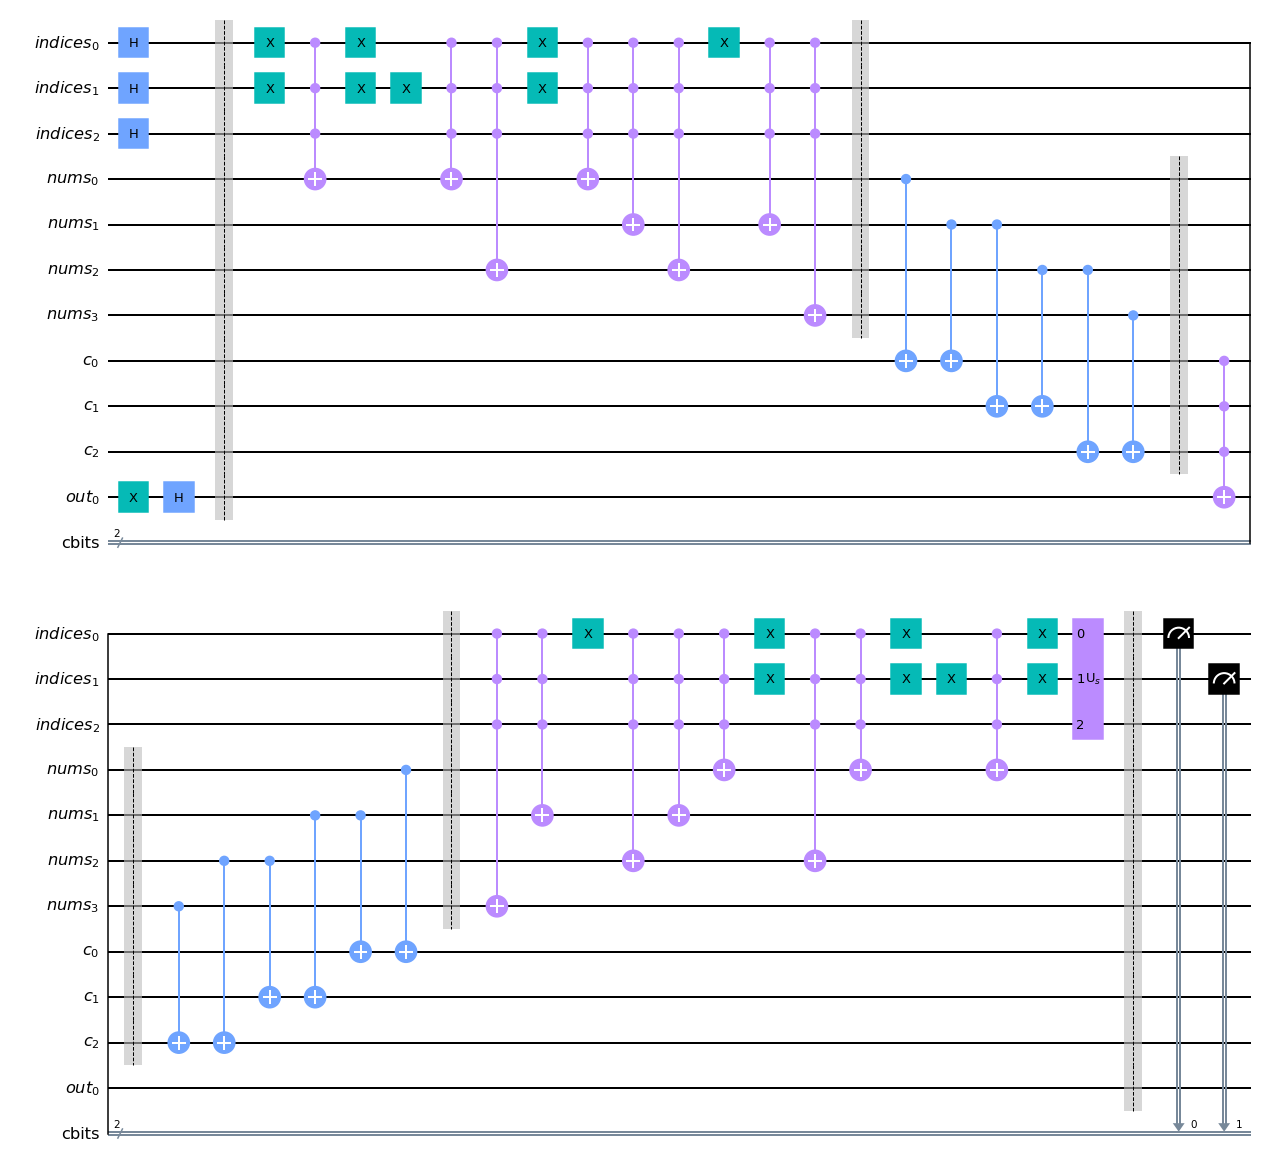

In [5]:
indices = QuantumRegister(idx_length + extra, name='indices')
nums_qubits = QuantumRegister(bit_length, name='nums')
clause_qubits = QuantumRegister(len(clause_list), name='c')
oracle_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(idx_length, name='cbits')
measured_nums = ClassicalRegister(bit_length, name='cnums')
clause_cbits = ClassicalRegister(len(clause_list), name='cclause')
# qc = QuantumCircuit(indices, nums_qubits, 
#                     clause_qubits, oracle_qubit, 
#                     cbits, measured_nums, clause_cbits)
qc = QuantumCircuit(indices, nums_qubits, 
                    clause_qubits, oracle_qubit, 
                    cbits)

# qc.draw('mpl')

qc.x(oracle_qubit)
qc.h(oracle_qubit)
# qc.initialize([1, -1]/np.sqrt(2), oracle_qubit)

qc.h(indices)

qc.barrier()
# qc.draw('mpl')
def task1oracle(qc, indices, nums, nums_qubits, clause_list, clause_qubits):
    def clauses():
        qc = QuantumCircuit(nums_qubits, clause_qubits)
        i = 0
        for clause in clause_list:
            XOR(qc, nums_qubits[clause[0]], nums_qubits[clause[1]], clause_qubits[i])
            i += 1
        qc.barrier()
        return qc
    def qram():
        qc = QuantumCircuit(indices, nums_qubits)
        for i in range(len(nums)):
            for j in range(idx_length):
                if (i & (1 << j)) == 0:
                    qc.x(j)
            num_bits = getBits(nums[i])
            for j in num_bits:
                qc.mct(indices, nums_qubits[j])
            for j in range(idx_length):
                if (i & (1 << j)) == 0:
                    qc.x(j)
        qc.barrier()
        return qc
    qc += qram()  
    qc += clauses()
    qc.mct(clause_qubits, oracle_qubit)
    qc += clauses().inverse()
    qc += qram().inverse()

num_of_iterations = round(
    np.pi / 4 * math.sqrt(len(nums) / 2))
print("num_of_iterations = ", num_of_iterations)
for i in range(num_of_iterations):
    task1oracle(qc, indices, nums, nums_qubits, clause_list, clause_qubits)
    qc.append(diffuser(idx_length+extra), list(range(idx_length + extra)))
#     qc.append(diffuser(2), indices)
    qc.barrier()
qc.measure(indices[:idx_length], cbits)
# qc.measure(nums_qubits, measured_nums)
# qc.measure(clause_qubits, clause_cbits)
qc.draw('mpl')

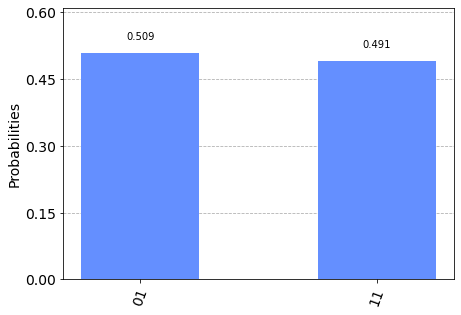

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)